In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pmdarima.utils import tsdisplay, autocorr_plot, decomposed_plot, plot_acf, plot_pacf
import warnings
warnings.filterwarnings("ignore")

Importação e tratamento de dados

In [67]:
df = pd.read_csv('datasets/Ibovespa14anos.csv',parse_dates=['Data'])
display(df.head())

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,2024-05-24,124.306,124.731,125.257,124.259,"9,21M","-0,34%"
1,2024-05-23,124.729,125.650,125.665,124.431,"9,99M","-0,73%"
2,2024-05-22,125.650,127.412,127.412,125.524,"12,40M","-1,38%"
3,2024-05-21,127.412,127.754,128.272,127.205,"9,14M","-0,27%"
4,2024-05-20,127.751,128.151,128.730,127.488,"9,34M","-0,31%"


In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3566 entries, 0 to 3565
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Data      3566 non-null   datetime64[ns]
 1   Último    3566 non-null   float64       
 2   Abertura  3566 non-null   float64       
 3   Máxima    3566 non-null   float64       
 4   Mínima    3566 non-null   float64       
 5   Vol.      3565 non-null   object        
 6   Var%      3566 non-null   object        
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 195.1+ KB


In [69]:
#  Excluindo a coluna Var% pois não terá utilizade posteriormente
df_new = df.copy().drop(columns='Var%')

In [70]:
# Renomeando as colunas para padronização
df_new.rename(columns={'Data':'ds','Último':'y','Abertura':'abertura','Máxima':'maxima','Mínima':'minima','Vol.':'volume'}, inplace=True)

In [71]:
# removendo valores nulos da coluna volume
df_new['volume'].fillna('0', inplace=True)

In [72]:
# Removendo 'M' e 'K' da coluna volume além de converter para float
df_new['volume'] = df_new['volume'].str.replace('M','',regex=False).str.replace(',','.',regex=False).str.replace('K','',regex=False).str.replace(',','.',regex=False).astype(float)
df_new.head()

,ds,y,abertura,maxima,minima,volume
0,2024-05-24,124.306,124.731,125.257,124.259,9.21
1,2024-05-23,124.729,125.650,125.665,124.431,9.99
2,2024-05-22,125.650,127.412,127.412,125.524,12.40
3,2024-05-21,127.412,127.754,128.272,127.205,9.14
4,2024-05-20,127.751,128.151,128.730,127.488,9.34


In [73]:
# Multiplicando a coluna volume por 1.000.000
df_new['volume'] = df_new['volume'] * 1_000_000

In [74]:
# Criando as colunas dia, mes e ano
df_new['dia'] = df_new['ds'].dt.day
df_new['mes'] = df_new['ds'].dt.month
df_new['ano'] = df_new['ds'].dt.year
df_new['dia_semana']=df_new['ds'].dt.day_of_week

Estátisticas descritivas

In [75]:
df_new.describe()

,ds,y,abertura,maxima,minima,volume,dia,mes,ano,dia_semana
count,3566,3566.000000,3566.000000,3566.000000,3566.000000,3.566000e+03,3566.000000,3566.000000,3566.000000,3566.000000
mean,2017-03-16 02:09:37.453730048,79.107269,79.092429,79.824282,78.365663,8.865993e+06,15.753505,6.405216,2016.715087,1.998598
min,2010-01-04 00:00:00,37.497000,37.501000,38.031000,37.046000,0.000000e+00,1.000000,1.000000,2010.000000,0.000000
25%,2013-08-08 06:00:00,56.496000,56.500500,57.099500,55.958250,2.990000e+06,8.000000,3.000000,2013.000000,1.000000
50%,2017-03-15 12:00:00,68.822500,68.807000,69.431000,68.268500,4.140000e+06,16.000000,6.000000,2017.000000,2.000000
75%,2020-10-21 18:00:00,104.370000,104.360000,105.178750,103.448500,8.810000e+06,23.000000,9.000000,2020.000000,3.000000
max,2024-05-24 00:00:00,134.194000,134.194000,134.392000,133.832000,9.816300e+08,31.000000,12.000000,2024.000000,4.000000
std,NaN,26.126225,26.115477,26.280249,25.951743,4.863969e+07,8.743763,3.424418,4.165864,1.410539


Visualização da relação de data(ds), valores de abertura, fechamento, valor mínimo e máximo

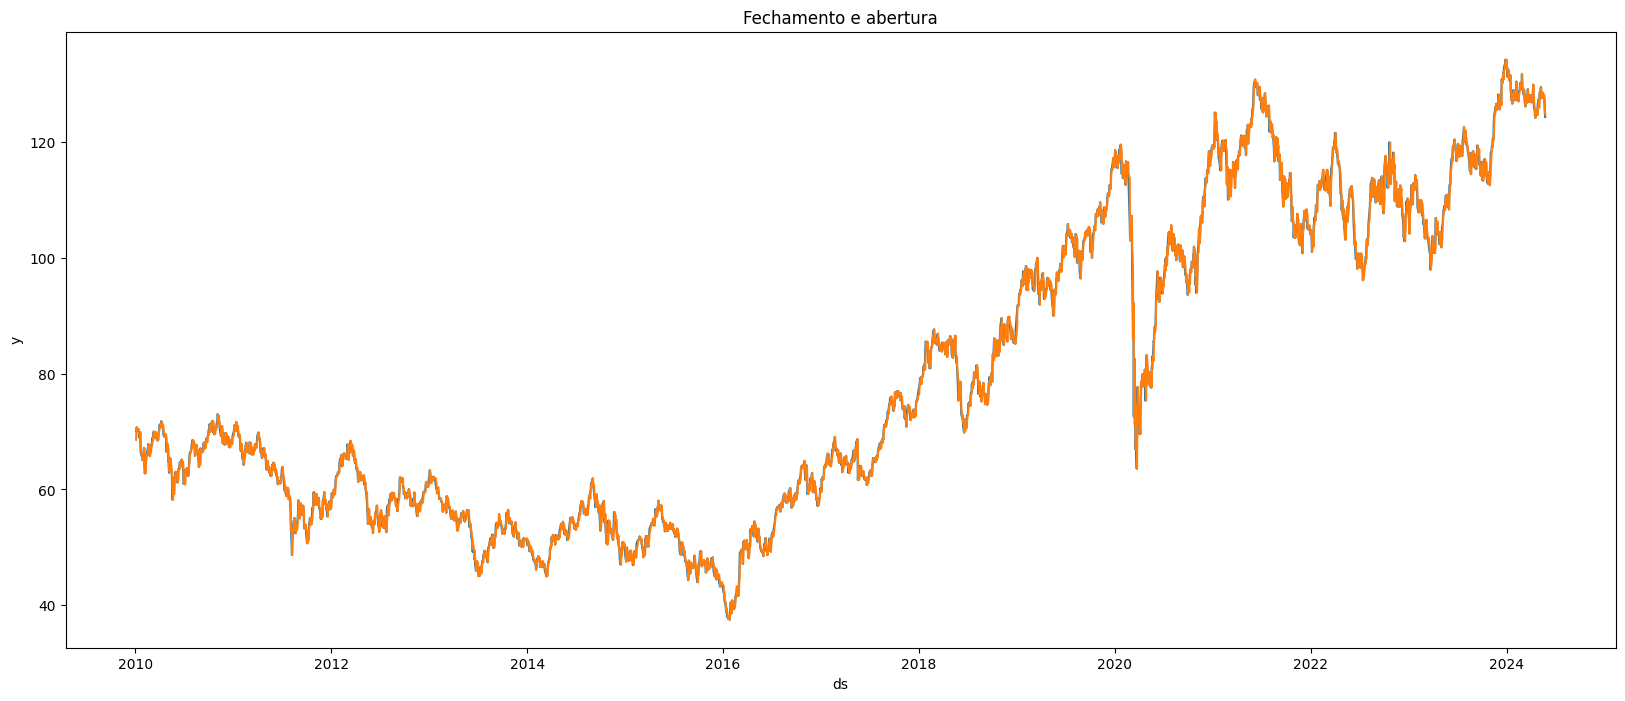

In [76]:
plt.figure(figsize=(20,8))
sns.lineplot(x='ds',y='y',data= df_new)
sns.lineplot(x='ds',y='abertura',data= df_new)
plt.title('Fechamento e abertura')
plt.show()

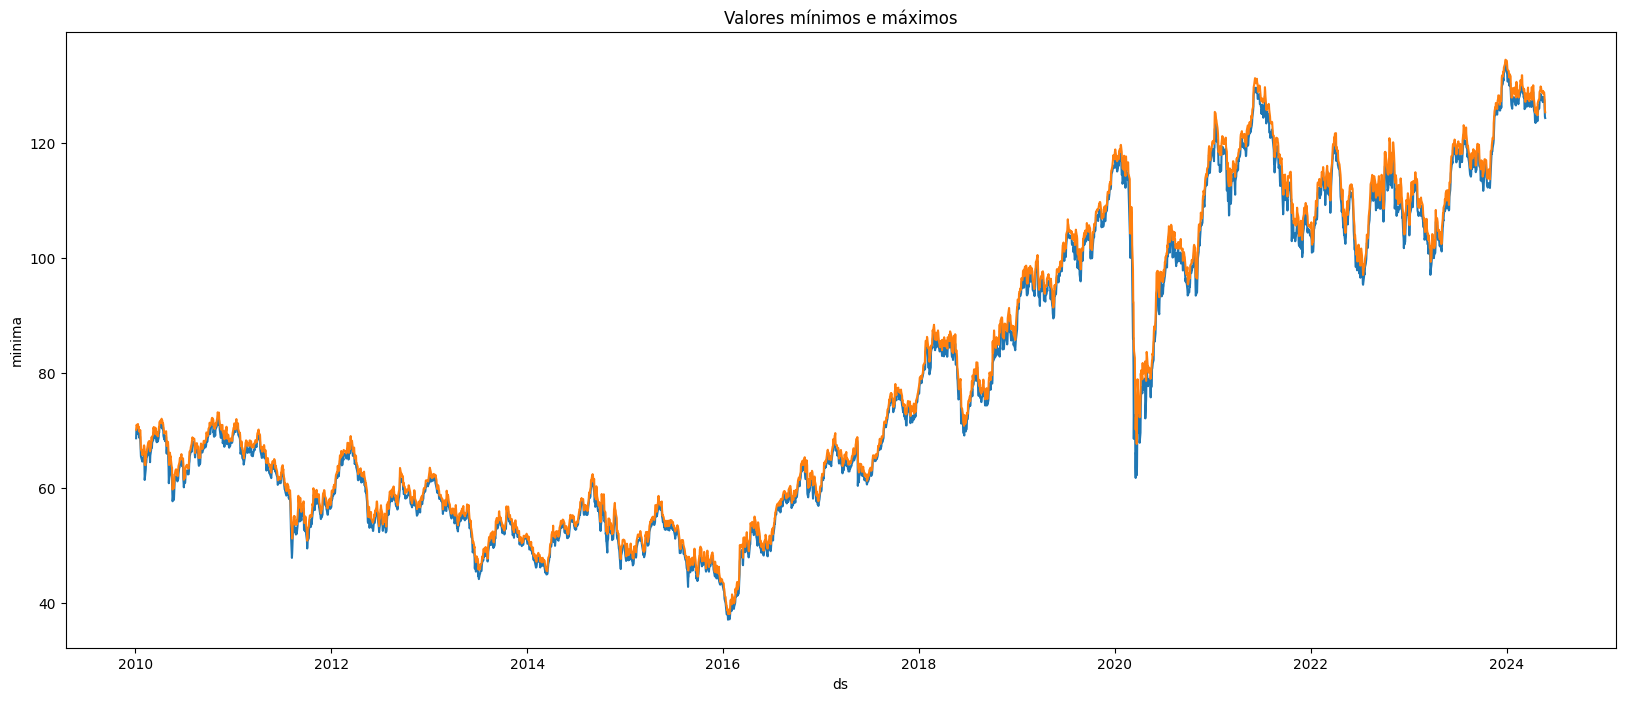

In [77]:
plt.figure(figsize=(20,8))
sns.lineplot(x='ds',y='minima',data= df_new)
sns.lineplot(x='ds',y='maxima',data= df_new)
plt.title('Valores mínimos e máximos')
plt.show()

Visualização da matriz de correlação

In [78]:
corr = df_new.corr()
corr.style.background_gradient(cmap='coolwarm')

,ds,y,abertura,maxima,minima,volume,dia,mes,ano,dia_semana
ds,1.000000,0.836637,0.836333,0.838143,0.835295,0.002647,0.004094,0.015701,0.997635,0.000203
y,0.836637,1.000000,0.998987,0.999561,0.999660,0.023665,-0.002941,-0.024606,0.837280,0.002516
abertura,0.836333,0.998987,1.000000,0.999591,0.999392,0.024137,-0.001496,-0.025620,0.837037,0.002793
maxima,0.838143,0.999561,0.999591,1.000000,0.999443,0.023716,-0.003236,-0.024826,0.838800,0.002558
minima,0.835295,0.999660,0.999392,0.999443,1.000000,0.024140,-0.001405,-0.024452,0.835920,0.002085
volume,0.002647,0.023665,0.024137,0.023716,0.024140,1.000000,-0.006443,0.004172,0.002390,-0.029132
dia,0.004094,-0.002941,-0.001496,-0.003236,-0.001405,-0.006443,1.000000,0.000573,-0.001682,-0.006624
mes,0.015701,-0.024606,-0.025620,-0.024826,-0.024452,0.004172,0.000573,1.000000,-0.052821,-0.006038
ano,0.997635,0.837280,0.837037,0.838800,0.835920,0.002390,-0.001682,-0.052821,1.000000,0.000648
dia_semana,0.000203,0.002516,0.002793,0.002558,0.002085,-0.029132,-0.006624,-0.006038,0.000648,1.000000


Criação do dataframe contendo apenas data e valor final

In [79]:
df_data = df_new[['ds','y']].set_index('ds')

In [80]:
df_data.sort_index(inplace=True)

Análise de sazonalidade, tendência e ruído

In [81]:
resultados = seasonal_decompose(df_data, period=30)

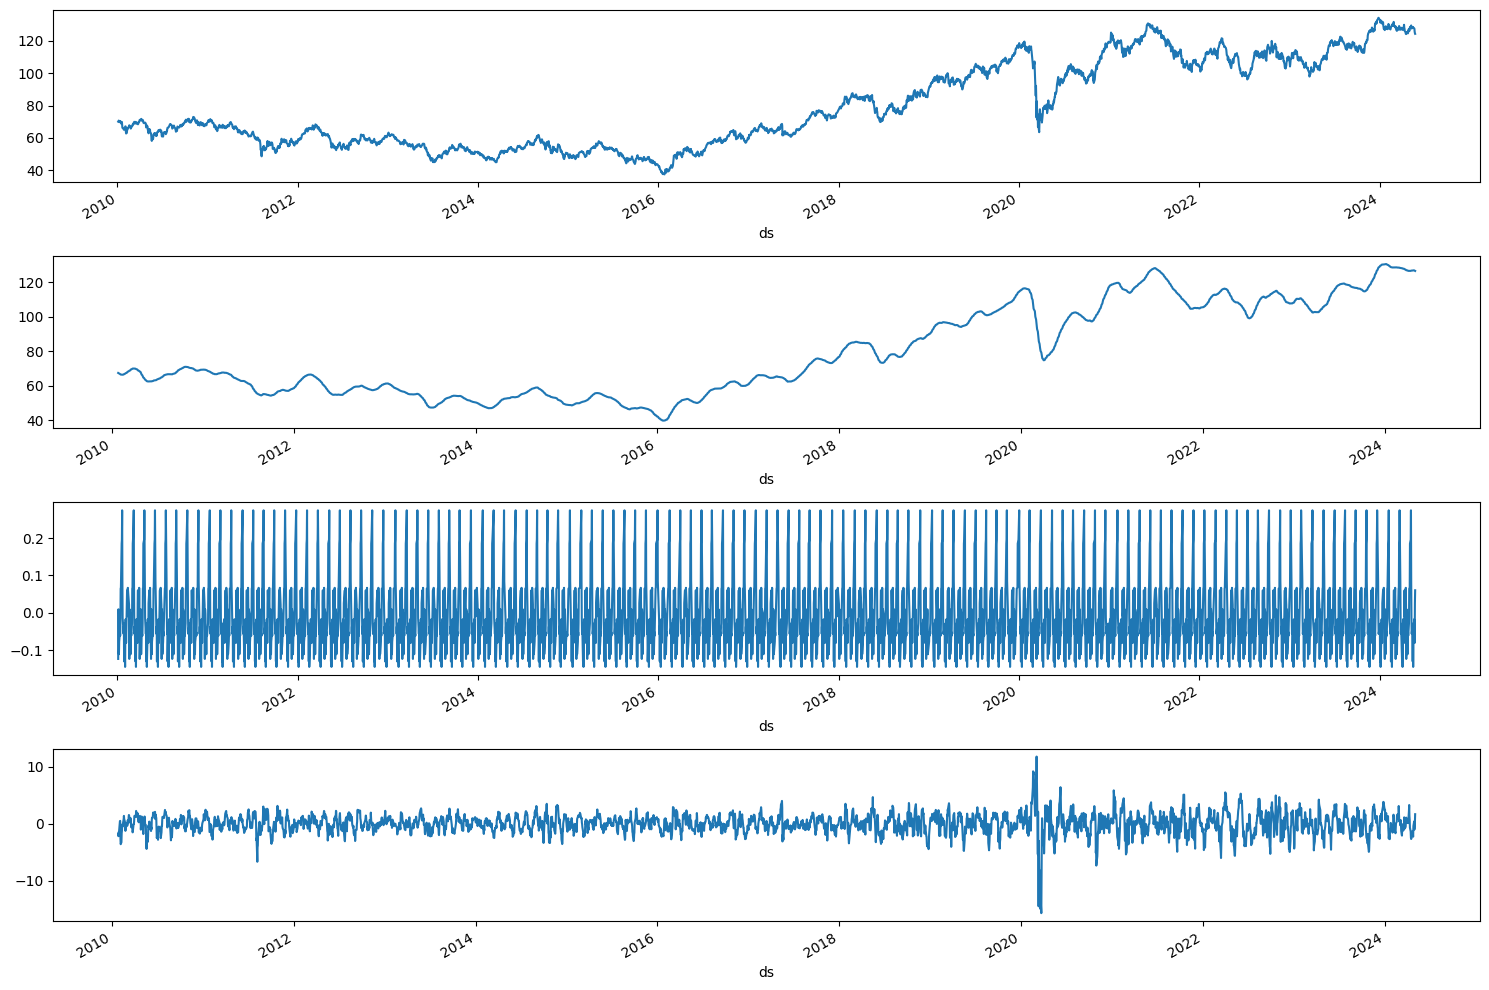

In [82]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(15,10))
resultados.observed.plot(ax=ax1)
resultados.trend.plot(ax=ax2)
resultados.seasonal.plot(ax=ax3)
resultados.resid.plot(ax=ax4)
plt.tight_layout()

Análise de dados estacionários e não=estacionários (pValue < 0.05)

In [83]:
x = df_data.y.values

In [84]:
result = adfuller(x)

print("teste ADF")
print(f'teste estatístico {result[0]}')
print(f"pValue {result[1]}")

for key, valor in result[4].items():
    print(f"Valores críticos")
    print(f"\t{key}:{valor}")

teste ADF
teste estatístico -0.8227934557399478
pValue 0.8123348080420478
Valores críticos
	1%:-3.4321892422972575
Valores críticos
	5%:-2.8623526737372837
Valores críticos
	10%:-2.5672025996313876


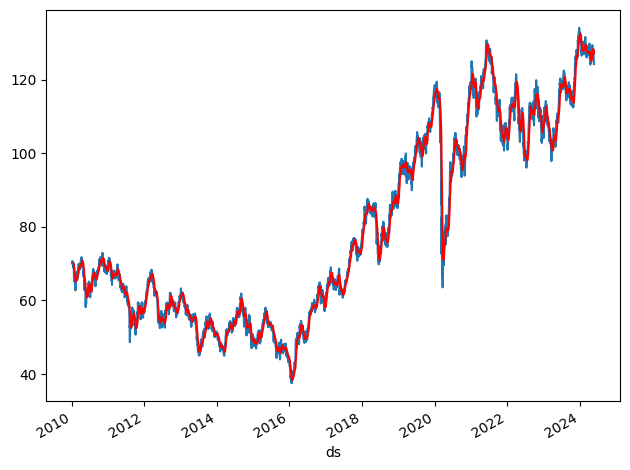

In [85]:
ma = df_data.rolling(12).mean()

fig, ax = plt.subplots()
df_data.plot(ax=ax,legend=False)
ma.plot(ax=ax, legend=False,color='r')
plt.tight_layout()

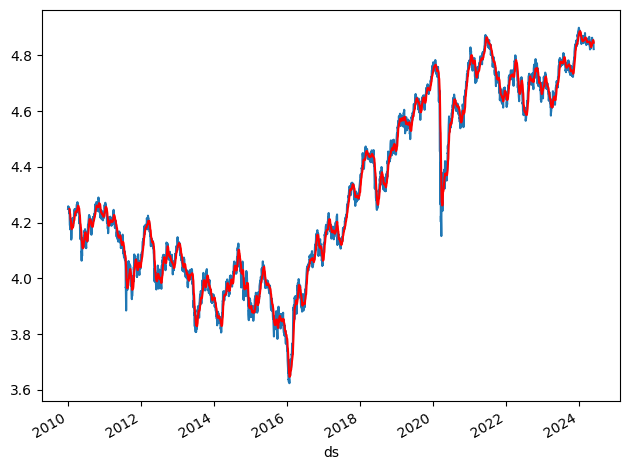

In [86]:
df_log = np.log(df_data)
ma_log = df_log.rolling(12).mean()

fig, ax = plt.subplots()
df_log.plot(ax=ax,legend=False)
ma_log.plot(ax=ax, legend=False,color='r')
plt.tight_layout()

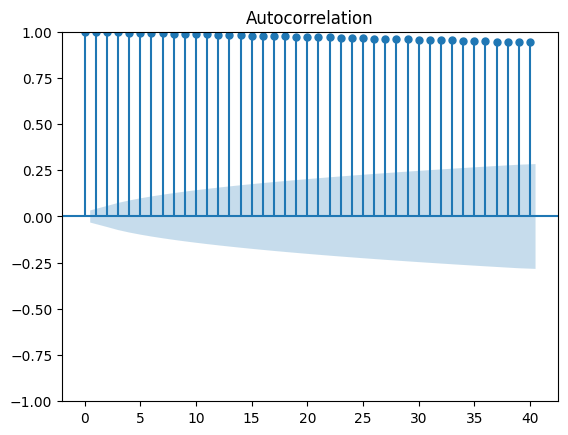

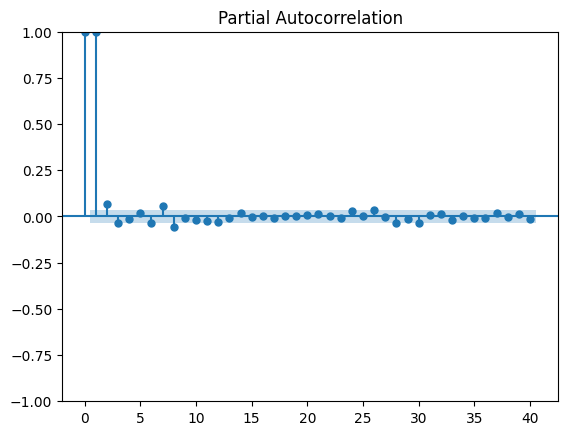

In [87]:
plot_acf(df_log['y'], lags=40, alpha=0.05)
plot_pacf(df_log['y'], lags=40, alpha=0.05)
plt.show()